# Deciphering Central Banks

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf

## 1. Data


In [98]:
df_ecb_sent=pd.read_csv('/Users/alexandrabessarabova/code/bess92/Deciphering_Central_Banks/raw_data/ECB_prelabelled_sent.csv')
df_fed_sent=pd.read_csv('/Users/alexandrabessarabova/code/bess92/Deciphering_Central_Banks/raw_data/FED_prelabelled_sent.csv')
df_bis_sent=pd.read_csv('/Users/alexandrabessarabova/code/bess92/Deciphering_Central_Banks/raw_data/BIS_prelabelled_sent.csv')
df_ecb_ag=pd.read_csv('/Users/alexandrabessarabova/code/bess92/Deciphering_Central_Banks/raw_data/ECB_prelabelled.csv')
df_fed_ag=pd.read_csv('/Users/alexandrabessarabova/code/bess92/Deciphering_Central_Banks/raw_data/FED_prelabelled.csv',lineterminator='\n')
df_bis_ag=pd.read_csv('/Users/alexandrabessarabova/code/bess92/Deciphering_Central_Banks/raw_data/BIS_prelabelled.csv')

df_fed_sent.drop(columns=['audience'],inplace=True)
df_fed_sent.head()
df_bis_ag.head()
df_bis_ag.drop(columns=['Unnamed: 0'],inplace=True)
df_ecb_ag.drop(columns=['Unnamed: 0'],inplace=True)


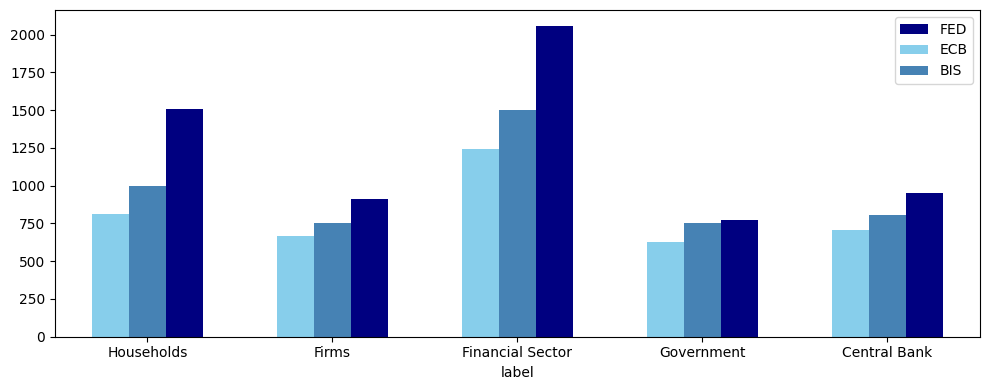

In [99]:
plt.figure(figsize=(10, 4))
width = .2
agents = ('Households', 'Firms', 'Financial Sector', 'Government', 'Central Bank')
ax1 = df_fed_ag['label'].value_counts().sort_index().plot(kind='bar', color='navy', position=-.5, width = width, label="FED")
ax2 = df_ecb_ag['label'].value_counts().sort_index().plot(kind='bar', color='skyblue', position=1.5, width = width, label='ECB')
ax3 = df_bis_ag['label'].value_counts().sort_index().plot(kind='bar', color='steelblue', position=0.5, width = width, label='BIS')
plt.xticks(range(0,5), agents, rotation = 0)
plt.xlim((-0.5, 4.5))
plt.legend()
plt.tight_layout();

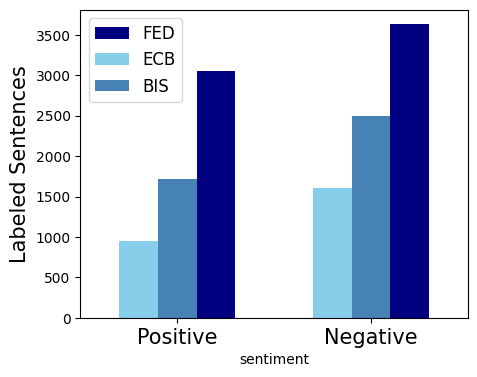

In [100]:
plt.figure(figsize=(5, 4))
width = .2
sentiment = ('Positive', 'Negative')
ax1 = df_fed_sent['sentiment'].value_counts().sort_index(ascending=False).plot(kind='bar', color='navy', position=-.5, width = width, label="FED")
ax2 = df_ecb_sent['sentiment'].value_counts().sort_index(ascending=False).plot(kind='bar', color='skyblue', position=1.5, width = width, label='ECB')
ax3 = df_bis_sent['sentiment'].value_counts().sort_index(ascending=False).plot(kind='bar', color='steelblue', position=0.5, width = width, label='BIS')
plt.xticks(range(0,2), sentiment, rotation = 0, fontsize=15)
plt.ylabel("Labeled Sentences", fontsize=15)
plt.xlim((-0.5, 1.5))
plt.legend(fontsize=12)
plt.show()

In [101]:
df_sent=pd.concat([df_ecb_sent,df_fed_sent,df_bis_sent],axis=0)
df_sent.head()
df_sent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13458 entries, 0 to 4211
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       13458 non-null  object
 1   sentiment  13458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 315.4+ KB


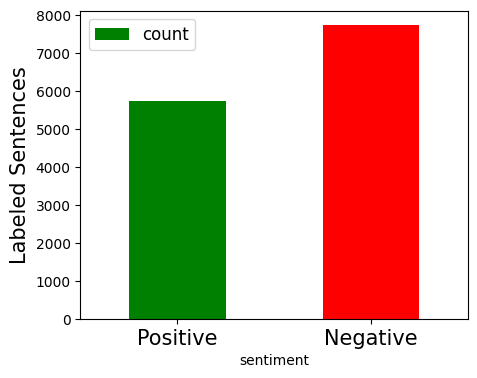

In [102]:
plt.figure(figsize=(5, 4))
sentiment = ('Positive', 'Negative')
ax1 = df_sent['sentiment'].value_counts().sort_index(ascending=False).plot(kind='bar',color = ['green', 'red'])
plt.xticks(range(0,2), sentiment, rotation = 0, fontsize=15)
plt.ylabel("Labeled Sentences", fontsize=15)
plt.xlim((-0.5, 1.5))
plt.legend(fontsize=12)
plt.show()

In [103]:
df_ag=pd.concat([df_ecb_ag,df_fed_ag,df_bis_ag],axis=0)
df_ag.columns=['text','agent']
df_ag.head()
df_ag.info()


<class 'pandas.core.frame.DataFrame'>
Index: 15060 entries, 0 to 4803
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    15060 non-null  object
 1   agent   15060 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 353.0+ KB


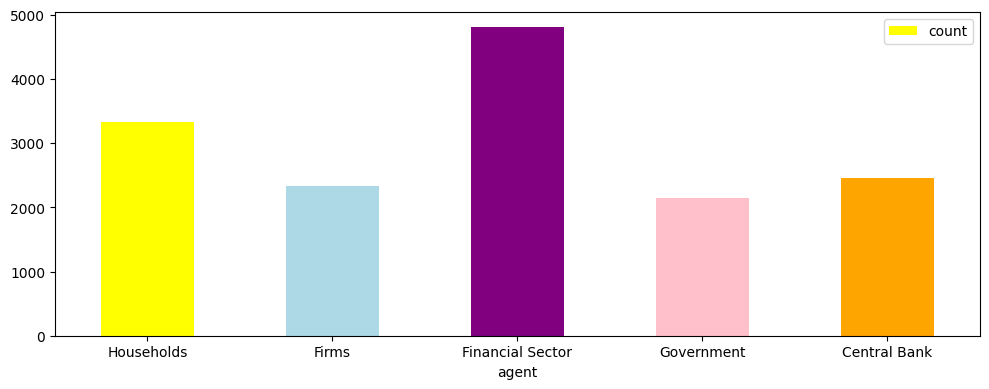

In [104]:
plt.figure(figsize=(10, 4))
agents = ('Households', 'Firms', 'Financial Sector', 'Government', 'Central Bank')
ax1 = df_ag['agent'].value_counts().sort_index().plot(kind='bar', color = ['yellow', 'lightblue', 'purple', 'pink', 'orange'])
plt.xticks(range(0,5), agents, rotation = 0)
plt.xlim((-0.5, 4.5))
plt.legend()
plt.tight_layout();

We are looking at fairly balanced dataset in terms of sentiment classes although as expected negative  slightly outweighs the positive as CBs are looking more at problems.
Equally for agents, financial sector is better represented as a class, which is also somewhat expected given this is key target of monitary policy.

Split the data for sentiment analysis:

In [105]:
X1_train, X1_test, y1_train, y1_test = train_test_split(df_sent['text'], df_sent['sentiment'], test_size=0.2, random_state=42, stratify=df_sent['sentiment'])

Split the data for agent analysis:


In [106]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df_ag['text'], df_ag['agent'], test_size=0.2, random_state=42, stratify=df_ag['agent'])

## 2. Machine Learning models

## 2.1 Multinomial Naive Bayes

We will use Tfidf Vectorizer to turn words into vectors and n-grams of range (1,3) to capture more complex word context:

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

It is best practice to remove stop words and lemmatize before using the models.

In [108]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
words_to_keep=['no','not','none',
    'not',
    'none',
    'neither',
    'never',
    'nobody',
    'nothing',
    'nowhere']
filtered_stop_words = [word for word in stop_words if word not in words_to_keep]

def clean (text,remove_stopwords=True):
    text=text.split()
    if remove_stopwords:
        words = [word for word in text if word not in filtered_stop_words] # Remove Stop Words
    else:
        words=text
    lemma=WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in words] # Lemmatize
    cleaned = ' '.join(lemmatized) # Join back to a string
    return cleaned


In [109]:
X1_train_clean=X1_train.apply(lambda x: clean(x,remove_stopwords=False))
X2_train_clean=X2_train.apply(clean)
X1_test_clean=X1_test.apply(lambda x: clean(x,remove_stopwords=False))
X2_test_clean=X2_test.apply(clean)

In [110]:
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
X1_train_vec=tf_idf_vectorizer.fit_transform(X1_train)
X2_train_vec=tf_idf_vectorizer.fit_transform(X2_train)

### Sentiment

In [111]:
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

# Pipeline vectorizer + Naive Bayes
pipeline_naive_bayes = make_pipeline(
    tf_idf_vectorizer,
    MultinomialNB()
)

# Cross-validation
cv_results = cross_validate(pipeline_naive_bayes, X1_train_clean, y1_train, cv = 5, scoring = ["average_precision"])
average_precision = cv_results["test_average_precision"].mean()
baseline_nb=np.round(average_precision,2)
print(baseline_nb)

0.9


Baseline Naive Bayes score is 0.89, which is actually quite decent but let's see if we can fine-tune some of the parameters of the vectorizer and the model alpha to get a better score!

In [112]:
from sklearn.model_selection import GridSearchCV


# Define the grid of parameters
parameters = {
    'tfidfvectorizer__ngram_range': ((1,1), (2,2),(1,2),(1,3)),
    'multinomialnb__alpha': (0.1,0.25,0,5,1)
}

# Perform Grid Search
grid_search1 = GridSearchCV(
    pipeline_naive_bayes,
    parameters,
    scoring = "average_precision",
    cv = 5,
    n_jobs=-1,
    verbose=1
)

grid_search1.fit(X1_train_clean,y1_train)

# Best score
print(f"Best Score = {grid_search1.best_score_}")

# Best params
print(f"Best params = {grid_search1.best_params_}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:126: RuntimeWarning: invalid value encountered in subtract
  return jll - np.atleast_2d(log_prob_x).T
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/decipherin

Best Score = 0.8992578866180608
Best params = {'multinomialnb__alpha': 0.25, 'tfidfvectorizer__ngram_range': (1, 2)}


In [113]:
best_pipeline_nb1=make_pipeline(TfidfVectorizer(ngram_range=(1,2)),MultinomialNB(alpha=0.25))
best_pipeline_nb1.fit(X1_train_clean, y1_train)
y1_pred_nb = best_pipeline_nb1.predict(X1_test_clean)
nb_report1 = pd.DataFrame(classification_report(y1_test, y1_pred_nb,output_dict=True)).transpose()
nb_report1

,precision,recall,f1-score,support
0,0.809955,0.926261,0.864212,1546.000000
1,0.876623,0.706806,0.782609,1146.000000
accuracy,0.832838,0.832838,0.832838,0.832838
macro avg,0.843289,0.816534,0.823411,2692.000000
weighted avg,0.838336,0.832838,0.829473,2692.000000


So fine-tune helped us get the baseline score to 0.89 which is already pretty good. Let's now do the same for the agent classification!
Since it's a multiclass classification let's create a custom scorer to help us with the task.

### Agents

In [114]:
# Create custom scorer
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer

def multiclass_precision(y_true, y_pred):
    # Calculate precision for all classes
    precisions = precision_score(y_true, y_pred, average=None, zero_division=0)

    # Convert the precision scores to a list
    return np.mean((precisions.tolist()))

scorer = make_scorer(multiclass_precision)

In [115]:
# Cross-validation
pipeline_nb2 = make_pipeline(
    tf_idf_vectorizer,
    MultinomialNB()
)
cv_results_nb2 = cross_validate(pipeline_nb2, X2_train_clean, y2_train, cv = 5, scoring = scorer )
average_precision_nb2 = cv_results_nb2["test_score"].mean()
baseline_nb2=np.round(average_precision_nb2,2)
print(baseline_nb2)

0.89


In [116]:
# Perform Grid Search
grid_search_nb2 = GridSearchCV(
    pipeline_nb2,
    parameters,
    scoring = scorer,
    cv = 5,
    n_jobs=-1,
    verbose=0
)

grid_search_nb2.fit(X2_train_clean,y2_train)

# Best score
print(f"Best Score = {grid_search_nb2.best_score_}")

# Best params
print(f"Best params = {grid_search_nb2.best_params_}")


/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/sklearn/naive_bayes.py:890: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = np.log(smoothed_fc) - np.log(
/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/

Best Score = 0.8937665778045065
Best params = {'multinomialnb__alpha': 0.25, 'tfidfvectorizer__ngram_range': (1, 3)}


In [117]:
best_pipeline_nb2=make_pipeline(tf_idf_vectorizer,MultinomialNB(alpha=0.25))
best_pipeline_nb2.fit(X2_train_clean, y2_train)
y2_pred_nb = best_pipeline_nb2.predict(X2_test_clean)
nb_report2 = pd.DataFrame(classification_report(y2_test, y2_pred_nb,output_dict=True)).transpose()
nb_report2

,precision,recall,f1-score,support
0,0.873668,0.863158,0.868381,665.000000
1,0.932961,0.718280,0.811665,465.000000
2,0.763519,0.984391,0.860000,961.000000
3,0.985119,0.771562,0.865359,429.000000
4,0.947867,0.813008,0.875274,492.000000
accuracy,0.858234,0.858234,0.858234,0.858234
macro avg,0.900627,0.830080,0.856136,3012.000000
weighted avg,0.875672,0.858234,0.857647,3012.000000


## 2.2 SVM 

### Sentiment 

In [118]:
from sklearn.svm import SVC
svm = SVC()
# Pipeline vectorizer + SVM
pipeline_svm = make_pipeline(
    tf_idf_vectorizer,
    svm
)
cv_results_svm1 = cross_validate(pipeline_svm, X1_train_clean, y1_train, cv = 3, scoring = ["average_precision"])
average_precision_svm1 = cv_results_svm1["test_average_precision"].mean()
print(np.round(average_precision,2))


0.9


In [119]:
# Define the grid of parameters
parameters_svm = {
    'svc__kernel': ['sigmoid', 'rbf', 'poly'],
    'svc__C': [0.1, 1,10],
    'svc__gamma': [0.01,0.1,0.5]
}

# Perform Grid Search
grid_search_svm1 = GridSearchCV(
    pipeline_svm,
    parameters_svm,
    scoring = "average_precision",
    cv = 5,
    n_jobs=-1,
    verbose=0
)

grid_search_svm1.fit(X1_train_clean,y1_train)

# Best score
print(f"Best Score = {grid_search_svm1.best_score_}")

# Best params
print(f"Best params = {grid_search_svm1.best_params_}")


/Users/alexandrabessarabova/.pyenv/versions/3.10.6/envs/deciphering_cbs/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Score = 0.8909949009326568
Best params = {'svc__C': 10, 'svc__gamma': 0.5, 'svc__kernel': 'rbf'}


In [120]:
best_pipeline_svm1=make_pipeline(tf_idf_vectorizer,SVC(kernel='rbf',C=10, gamma=0.1))
best_pipeline_svm1.fit(X1_train_clean, y1_train)
y1_pred_svm = best_pipeline_svm1.predict(X1_test_clean)
svm_report1 = pd.DataFrame(classification_report(y1_test, y1_pred_svm,output_dict=True)).transpose()
svm_report1

,precision,recall,f1-score,support
0,0.838770,0.864812,0.851592,1546.000000
1,0.809654,0.775742,0.792335,1146.000000
accuracy,0.826895,0.826895,0.826895,0.826895
macro avg,0.824212,0.820277,0.821964,2692.000000
weighted avg,0.826375,0.826895,0.826366,2692.000000


### Agents

In [121]:
svm2 = SVC()

pipeline_svm2 = make_pipeline(
    tf_idf_vectorizer,
    svm2
)
cv_results_svm2 = cross_validate(pipeline_svm2, X2_train_clean, y2_train, cv = 5, scoring = scorer)
baseline_svm2 = cv_results_svm2["test_score"].mean()
print(baseline_svm2)


0.9133251246350997


In [122]:
# Perform Grid Search
parameters_svm2 = {
    'kernel': ['sigmoid', 'rbf', 'poly'],
    'C': [0.1, 1,10],
    'gamma': [0.01,0.1,0.5]
}


grid_search_svm2 = GridSearchCV(
    svm2,
    parameters_svm2,
    scoring = scorer,
    cv = 5,
    n_jobs=-1,
    verbose=0
)

grid_search_svm2.fit(X2_train_vec,y2_train)

# Best score
print(f"Best Score = {grid_search_svm2.best_score_}")

# Best params
print(f"Best params = {grid_search_svm2.best_params_}")


Best Score = 0.9114050809737979
Best params = {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}


In [123]:
best_pipeline_svm2=make_pipeline(tf_idf_vectorizer,SVC(kernel='rbf',C=10, gamma=0.5))
best_pipeline_svm2.fit(X2_train_clean, y2_train)
y2_pred_svm = best_pipeline_svm2.predict(X2_test_clean)
svm_report2 = pd.DataFrame(classification_report(y2_test, y2_pred_svm,output_dict=True)).transpose()
svm_report2

,precision,recall,f1-score,support
0,0.925466,0.896241,0.910619,665.000000
1,0.877682,0.879570,0.878625,465.000000
2,0.917918,0.954214,0.935714,961.000000
3,0.936118,0.888112,0.911483,429.000000
4,0.907258,0.914634,0.910931,492.000000
accuracy,0.914011,0.914011,0.914011,0.914011
macro avg,0.912888,0.906554,0.909475,3012.000000
weighted avg,0.914224,0.914011,0.913861,3012.000000


## 2.3 Random Forests

### Sentiment

In [124]:
from sklearn.ensemble import RandomForestClassifier
rf1=RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)
pipeline_rf1 = make_pipeline(
    tf_idf_vectorizer,
    rf1
)
cv_results_rf1 = cross_validate(pipeline_rf1, X1_train_clean, y1_train, scoring = "average_precision", cv=5)
baseline_rf1 = cv_results_rf1["test_score"].mean()
print(baseline_rf1)


0.8349405456814404


In [125]:
from sklearn.model_selection import KFold
parameters_rf = {
    'randomforestclassifier__max_leaf_nodes': [8,16,24,32],
    'randomforestclassifier__n_estimators': [50,100,200]
}
cv_test= KFold(n_splits=5)
grid_search_rf1 = GridSearchCV(
    pipeline_rf1,
    parameters_rf,
    scoring = 'average_precision',
    cv = cv_test,
    n_jobs=-1,
    verbose=1
)

grid_search_rf1.fit(X1_train_clean,y1_train)

# Best score
print(f"Best Score = {grid_search_rf1.best_score_}")

# Best params
print(f"Best params = {grid_search_rf1.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score = 0.8506211059487999
Best params = {'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__n_estimators': 200}


In [126]:
best_pipeline_rf1=make_pipeline(tf_idf_vectorizer,RandomForestClassifier(n_estimators=200, max_leaf_nodes=32, n_jobs=-1))
best_pipeline_rf1.fit(X1_train_clean, y1_train)
y1_pred_rf = best_pipeline_rf1.predict(X1_test)
rf_report1 = pd.DataFrame(classification_report(y1_test, y1_pred_rf,output_dict=True)).transpose()
rf_report1

,precision,recall,f1-score,support
0,0.668574,0.982536,0.795705,1546.000000
1,0.935714,0.342932,0.501916,1146.000000
accuracy,0.710253,0.710253,0.710253,0.710253
macro avg,0.802144,0.662734,0.648810,2692.000000
weighted avg,0.782297,0.710253,0.670637,2692.000000


### Agents

In [127]:
from sklearn.ensemble import RandomForestClassifier
rf2=RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)
pipeline_rf2 = make_pipeline(
    tf_idf_vectorizer,
    rf2
)
cv_results_rf2 = cross_validate(pipeline_rf2, X2_train_clean, y2_train, scoring = scorer, cv=5)
baseline_rf2 = cv_results_rf2["test_score"].mean()
print(baseline_rf2)


0.8672640257481031


In [128]:
from sklearn.model_selection import KFold
parameters_rf = {
    'randomforestclassifier__max_leaf_nodes': [8,16,24,32],
    'randomforestclassifier__n_estimators': [50,100,200]
}
cv_test= KFold(n_splits=5)
grid_search_rf2 = GridSearchCV(
    pipeline_rf2,
    parameters_rf,
    scoring = scorer,
    cv = cv_test,
    n_jobs=-1,
    verbose=1
)

grid_search_rf2.fit(X2_train_clean,y2_train)

# Best score
print(f"Best Score = {grid_search_rf2.best_score_}")

# Best params
print(f"Best params = {grid_search_rf2.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Score = 0.8805170512370877
Best params = {'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__n_estimators': 200}


In [129]:
best_pipeline_rf2=make_pipeline(tf_idf_vectorizer,RandomForestClassifier(n_estimators=200, max_leaf_nodes=32, n_jobs=-1))
best_pipeline_rf2.fit(X2_train_clean, y2_train)
y2_pred_rf = best_pipeline_rf2.predict(X2_test)
rf_report2 = pd.DataFrame(classification_report(y2_test, y2_pred_rf,output_dict=True)).transpose()
rf_report2

,precision,recall,f1-score,support
0,0.892453,0.711278,0.791632,665.000000
1,0.965217,0.238710,0.382759,465.000000
2,0.523731,0.987513,0.684457,961.000000
3,1.000000,0.447552,0.618357,429.000000
4,0.955923,0.705285,0.811696,492.000000
accuracy,0.687915,0.687915,0.687915,0.687915
macro avg,0.867465,0.618068,0.657780,3012.000000
weighted avg,0.811729,0.687915,0.672912,3012.000000


## 2.4 Combine all results

### Sentiment

In [140]:
nb_report1_mod=nb_report1.drop(columns=['support'])
svm_report1_mod=svm_report1.drop(columns=['support'])
rf_report1_mod=rf_report1.drop(columns=['support'])

In [141]:
nb_report1_mod['model']='NB'
accuracy_nb1=float(nb_report1.iloc[2,1])
nb_report1_mod=nb_report1_mod.iloc[[-1],:].reset_index()
nb_report1_mod['accuracy']=accuracy_nb1
nb_report1_mod.drop(columns=['index'],inplace=True)
nb_report1_mod.set_index('model',inplace=True)

In [142]:
svm_report1_mod['model']='SVM'
accuracy_svm1=float(svm_report1.iloc[2,1])
svm_report1_mod=svm_report1_mod.iloc[[-1],:].reset_index()
svm_report1_mod['accuracy']=accuracy_svm1
svm_report1_mod.drop(columns=['index'],inplace=True)
svm_report1_mod.set_index('model',inplace=True)

In [143]:
rf_report1_mod['model']='RF'
accuracy_rf1=float(rf_report1.iloc[2,1])
rf_report1_mod=rf_report1_mod.iloc[[-1],:].reset_index()
rf_report1_mod['accuracy']=accuracy_rf1
rf_report1_mod.drop(columns=['index'],inplace=True)
rf_report1_mod.set_index('model',inplace=True)

In [151]:
sent_report=pd.concat([nb_report1_mod,svm_report1_mod,rf_report1_mod],axis=0)
sent_report.round(3)

,precision,recall,f1-score,accuracy
model,,,,
NB,0.838,0.833,0.829,0.833
SVM,0.826,0.827,0.826,0.827
RF,0.782,0.710,0.671,0.710


### Agents

In [145]:
nb_report2_mod=nb_report2.drop(columns=['support'])
svm_report2_mod=svm_report2.drop(columns=['support'])
rf_report2_mod=rf_report2.drop(columns=['support'])

In [146]:
nb_report2_mod['model']='NB'
accuracy_nb2=float(nb_report2.iloc[5,1])
nb_report2_mod=nb_report2_mod.iloc[[7],:].reset_index()
nb_report2_mod['accuracy']=accuracy_nb2
nb_report2_mod.drop(columns=['index'],inplace=True)
nb_report2_mod.set_index('model',inplace=True)

In [147]:
rf_report2['model']='RF'
accuracy_rf2=float(rf_report2.iloc[5,1])
rf_report2_mod=rf_report2_mod.iloc[[7],:].reset_index()
rf_report2_mod['accuracy']=accuracy_rf2
rf_report2_mod.drop(columns=['index'],inplace=True)
rf_report2_mod.set_index('model',inplace=True)

In [148]:
svm_report2_mod['model']='SVM'
accuracy_svm2=float(svm_report2.iloc[5,1])
svm_report2_mod=svm_report2_mod.iloc[[7],:].reset_index()
svm_report2_mod['accuracy']=accuracy_svm2
svm_report2_mod.drop(columns=['index'],inplace=True)
svm_report2_mod.set_index('model',inplace=True)

In [150]:
agent_report=pd.concat([nb_report2_mod,svm_report2_mod,rf_report2_mod],axis=0)
agent_report.round(3)

,precision,recall,f1-score,accuracy
model,,,,
NB,0.876,0.858,0.858,0.858
SVM,0.914,0.914,0.914,0.914
RF,0.812,0.688,0.673,0.688


## 3. Deep Learning models

## 3.1 LSTM

In [152]:
from tensorflow.keras import Sequential, layers, callbacks, regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


### Sentiment LSTM

### Tokenizing/Embedding with Word2Vec

In [153]:

word2vec = Word2Vec(sentences=X1_train, vector_size=60, min_count=10, window=10)
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:

        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])

    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []

    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)

    return embed

# Embed the training and test sentences
X1_train_embed = embedding(word2vec, X1_train)
X1_test_embed = embedding(word2vec, X1_test)


# Pad the training and test embedded sentences
X1_train_pad = pad_sequences(X1_train_embed, dtype='float32', padding='post', maxlen=200)
X1_test_pad = pad_sequences(X1_test_embed, dtype='float32', padding='post', maxlen=200)

In [154]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [155]:
def initialize_model():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [156]:
def compile_model(model, optimizer_name):
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = optimizer_name,
        metrics = ['accuracy']
    )
    return model

In [157]:
es = EarlyStopping(patience=10, restore_best_weights=True)
model1 = compile_model(initialize_model(), 'rmsprop')
history1=model1.fit(X1_train_pad, y1_train,
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/100
236/236 [==============================] - 14s 48ms/step - loss: 0.6767 - accuracy: 0.5829 - val_loss: 0.6707 - val_accuracy: 0.5947
Epoch 2/100
236/236 [==============================] - 11s 45ms/step - loss: 0.6624 - accuracy: 0.6043 - val_loss: 0.6683 - val_accuracy: 0.5935
Epoch 3/100
236/236 [==============================] - 10s 44ms/step - loss: 0.6582 - accuracy: 0.6119 - val_loss: 0.6669 - val_accuracy: 0.5793
Epoch 4/100
236/236 [==============================] - 10s 44ms/step - loss: 0.6509 - accuracy: 0.6143 - val_loss: 0.6655 - val_accuracy: 0.6003
Epoch 5/100
236/236 [==============================] - 10s 44ms/step - loss: 0.6584 - accuracy: 0.6015 - val_loss: 0.6514 - val_accuracy: 0.6201
Epoch 6/100
236/236 [==============================] - 10s 44ms/step - loss: 0.6427 - accuracy: 0.6331 - val_loss: 0.6496 - val_accuracy: 0.6241
Epoch 7/100
236/236 [==============================] - 10s 44ms/step - loss: 0.6313 - accuracy: 0.6499 - val_loss: 0.6487 - val_ac

In [158]:
res=model1.evaluate(X1_test_pad, y1_test)
print(res)

85/85 [==============================] - 1s 11ms/step - loss: 0.6057 - accuracy: 0.6850
[0.6056727170944214, 0.6849925518035889]


In [159]:
import time
results = []

for optimizer in ['rmsprop', 'adam', 'adagrad']:
    start_time = time.time()

    model = compile_model(initialize_model(), optimizer)

    es = EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(
        X1_train_pad,
        y1_train,
        batch_size = 16,
        epochs = 200,
        validation_split = 0.3,
        callbacks = [es],
        verbose = 0
    )

    res = model.evaluate(X1_test_pad, y1_test)[1]
    results.append(res)

    end_time = time.time()

    print(f'Test accuracy with the {optimizer} optimizer: {res:.4f}  reached in {(end_time - start_time):.0f} s after {len(history.epoch)} epochs')

85/85 [==============================] - 1s 11ms/step - loss: 0.5738 - accuracy: 0.7140
Test accuracy with the rmsprop optimizer: 0.7140  reached in 326 s after 28 epochs
85/85 [==============================] - 1s 11ms/step - loss: 0.5671 - accuracy: 0.7236
Test accuracy with the adam optimizer: 0.7236  reached in 335 s after 28 epochs
85/85 [==============================] - 1s 11ms/step - loss: 0.6207 - accuracy: 0.6597
Test accuracy with the adagrad optimizer: 0.6597  reached in 2320 s after 200 epochs


Best optimizer is adam! Let's try different learning rates

In [160]:
learning_rates = [0.001, 0.01, 0.1]
results = []

for learning_rate in learning_rates:

    # 1. Instantiating the Adam optimizer with a specific learning_rate
    adam = Adam(learning_rate=learning_rate)

    # 2. Initializing the model
    model = initialize_model()

    # 3. Compiling the model with the custom Adam optimizer
    model = compile_model(model, adam)

    # 4. Training the neural net
    es = EarlyStopping(patience = 10)
    history = model.fit(
        X1_train_pad,
        y1_train,
        validation_split = 0.3,
        batch_size = 16,
        epochs = 50,
        callbacks = [es],
        verbose = 0
    )

    res = model.evaluate(X1_test_pad, y1_test)[1]
    results.append(res)

    print(f'Test accuracy with a learning rate of {learning_rate} --> {res:.4f}')

85/85 [==============================] - 1s 11ms/step - loss: 0.8494 - accuracy: 0.7125
Test accuracy with a learning rate of 0.001 --> 0.7125
85/85 [==============================] - 1s 11ms/step - loss: 0.5374 - accuracy: 0.7411
Test accuracy with a learning rate of 0.01 --> 0.7411
85/85 [==============================] - 1s 11ms/step - loss: 0.6840 - accuracy: 0.5743
Test accuracy with a learning rate of 0.1 --> 0.5743


Learning rate of 0.001 is the optimal one!

### Tokenizing/Embedding layers

In [161]:
tokenizer= Tokenizer()

tokenizer.fit_on_texts(X1_train)

X1_train_token = tokenizer.texts_to_sequences(X1_train)
X1_test_token = tokenizer.texts_to_sequences(X1_test)
vocab_size = len(tokenizer.word_index)


X1_train_tok_pad = pad_sequences(X1_train_token, dtype='float32', padding='post',maxlen=150)
X1_test_tok_pad = pad_sequences(X1_test_token, dtype='float32', padding='post',maxlen=150)

In [162]:
def initialize_model_embed():
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=50, mask_zero=True))
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [163]:
model_embed = compile_model(initialize_model_embed(), 'adam')

In [164]:

history1=model_embed.fit(X1_train_tok_pad, y1_train,
          batch_size = 32,
          epochs=50,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/50
236/236 [==============================] - 12s 41ms/step - loss: 0.4984 - accuracy: 0.7418 - val_loss: 0.3968 - val_accuracy: 0.8217
Epoch 2/50
236/236 [==============================] - 9s 38ms/step - loss: 0.2663 - accuracy: 0.8962 - val_loss: 0.4311 - val_accuracy: 0.8192
Epoch 3/50
236/236 [==============================] - 9s 38ms/step - loss: 0.1599 - accuracy: 0.9413 - val_loss: 0.5019 - val_accuracy: 0.8127
Epoch 4/50
236/236 [==============================] - 9s 39ms/step - loss: 0.0924 - accuracy: 0.9683 - val_loss: 0.7129 - val_accuracy: 0.7991
Epoch 5/50
236/236 [==============================] - 9s 37ms/step - loss: 0.0551 - accuracy: 0.9816 - val_loss: 0.6226 - val_accuracy: 0.7935
Epoch 6/50
236/236 [==============================] - 9s 37ms/step - loss: 0.0354 - accuracy: 0.9879 - val_loss: 0.9334 - val_accuracy: 0.8000
Epoch 7/50
236/236 [==============================] - 9s 37ms/step - loss: 0.0154 - accuracy: 0.9950 - val_loss: 1.3093 - val_accuracy: 0.767

Looks like the model is overfitting! Let's add some dropout layers and regularizer

In [165]:

reg_l1 = regularizers.L1(0.01)

def initialize_model_embed2():
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size+1, output_dim=50, mask_zero=True))
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.Dense(100, activation='relu',kernel_regularizer = reg_l1))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='relu',kernel_regularizer = reg_l1))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [166]:
model_embed2 = compile_model(initialize_model_embed2(), 'adam')

In [167]:

history2=model_embed2.fit(X1_train_tok_pad, y1_train,
          batch_size = 16,
          epochs=50,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/50
471/471 [==============================] - 12s 24ms/step - loss: 1.7248 - accuracy: 0.6168 - val_loss: 0.6439 - val_accuracy: 0.7678
Epoch 2/50
471/471 [==============================] - 11s 23ms/step - loss: 0.6048 - accuracy: 0.8183 - val_loss: 0.5974 - val_accuracy: 0.8111
Epoch 3/50
471/471 [==============================] - 11s 23ms/step - loss: 0.5197 - accuracy: 0.8591 - val_loss: 0.5509 - val_accuracy: 0.8062
Epoch 4/50
471/471 [==============================] - 11s 23ms/step - loss: 0.4501 - accuracy: 0.8988 - val_loss: 0.5446 - val_accuracy: 0.7932
Epoch 5/50
471/471 [==============================] - 11s 24ms/step - loss: 0.3956 - accuracy: 0.9140 - val_loss: 0.5645 - val_accuracy: 0.7994
Epoch 6/50
471/471 [==============================] - 11s 24ms/step - loss: 0.3555 - accuracy: 0.9273 - val_loss: 0.5994 - val_accuracy: 0.7938
Epoch 7/50
471/471 [==============================] - 11s 23ms/step - loss: 0.3249 - accuracy: 0.9348 - val_loss: 0.6546 - val_accuracy:

Try different stoppers!

In [168]:
LRreducer = callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, restore_best_weights=True)


In [169]:
history3 = model_embed2.fit(
        X1_train_tok_pad, y1_train,
        batch_size = 32,
        epochs=50,
        validation_split=0.3,
        callbacks = [LRreducer, EarlyStopper])

Epoch 1/50
236/236 [==============================] - 10s 38ms/step - loss: 0.2238 - accuracy: 0.9597 - val_loss: 0.9333 - val_accuracy: 0.7963 - lr: 0.0010
Epoch 2/50
236/236 [==============================] - 9s 38ms/step - loss: 0.2107 - accuracy: 0.9636 - val_loss: 1.0183 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 3/50
236/236 [==============================] - 9s 38ms/step - loss: 0.2083 - accuracy: 0.9651 - val_loss: 1.0276 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 4/50
236/236 [==============================] - 9s 38ms/step - loss: 0.1932 - accuracy: 0.9695 - val_loss: 1.0639 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 5/50
235/236 [============================>.] - ETA: 0s - loss: 0.2016 - accuracy: 0.9652
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
236/236 [==============================] - 9s 38ms/step - loss: 0.2015 - accuracy: 0.9652 - val_loss: 1.1778 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 6/50
236/236 [==============================] - 9s 

In [170]:
res_embed2=model_embed2.evaluate(X1_test_tok_pad, y1_test)
res_embed2

85/85 [==============================] - 1s 8ms/step - loss: 1.0570 - accuracy: 0.7901


[1.056950569152832, 0.7901188731193542]

In [171]:
y1_pred_lstm=[]
for i in model_embed2.predict(X1_test_tok_pad).flatten():
    if i<0.5:
        y1_pred_lstm.append(0)
    else:
        y1_pred_lstm.append(1)
lstm_report1 = pd.DataFrame(classification_report(y1_test, y1_pred_lstm,output_dict=True)).transpose()
lstm_report1


85/85 [==============================] - 1s 8ms/step


,precision,recall,f1-score,support
0,0.824619,0.805951,0.815178,1546.000000
1,0.745978,0.768761,0.757198,1146.000000
accuracy,0.790119,0.790119,0.790119,0.790119
macro avg,0.785299,0.787356,0.786188,2692.000000
weighted avg,0.791141,0.790119,0.790496,2692.000000


In [172]:
lstm_report1_mod=lstm_report1.drop(columns=['support'])
lstm_report1_mod['model']='LSTM'
accuracy_lstm1=float(lstm_report1.iloc[2,1])
lstm_report1_mod=lstm_report1_mod.iloc[[-1],:].reset_index()
lstm_report1_mod['accuracy']=accuracy_lstm1
lstm_report1_mod.drop(columns=['index'],inplace=True)
lstm_report1_mod.set_index('model',inplace=True)
lstm_report1_mod


,precision,recall,f1-score,accuracy
model,,,,
LSTM,0.791141,0.790119,0.790496,0.790119


In [196]:
sent_report_with_lstm=pd.concat([sent_report,lstm_report1_mod],axis=0)
sent_report_with_lstm.round(3)

,precision,recall,f1-score,accuracy
model,,,,
NB,0.838,0.833,0.829,0.833
SVM,0.826,0.827,0.826,0.827
RF,0.782,0.710,0.671,0.710
LSTM,0.791,0.790,0.790,0.790


### Agents LSTM

### Tokenizing/Embedding with Word2Vec

In [174]:
word2vec = Word2Vec(sentences=X2_train, vector_size=60, min_count=10, window=10)
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])

    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []

    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)

    return embed

# Embed the training and test sentences
X2_train_embed = embedding(word2vec, X2_train)
X2_test_embed = embedding(word2vec, X2_test)


# Pad the training and test embedded sentences
X2_train_pad = pad_sequences(X2_train_embed, dtype='float32', padding='post', maxlen=200)
X2_test_pad = pad_sequences(X2_test_embed, dtype='float32', padding='post', maxlen=200)


In [175]:
from tensorflow.keras.utils import to_categorical
y2_test_cat=to_categorical(y2_test)
y2_train_cat=to_categorical(y2_train)

In [176]:
def initialize_model_ag():
    model = Sequential()
    model.add(layers.Masking())
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))

    return model


In [177]:
model_ag1 = compile_model(initialize_model_ag(), 'rmsprop')
history1=model_ag1.fit(X2_train_pad, y2_train_cat,
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/100
264/264 [==============================] - 14s 47ms/step - loss: 0.4752 - accuracy: 0.3862 - val_loss: 0.4567 - val_accuracy: 0.3972
Epoch 2/100
264/264 [==============================] - 12s 44ms/step - loss: 0.4349 - accuracy: 0.4500 - val_loss: 0.3999 - val_accuracy: 0.5447
Epoch 3/100
264/264 [==============================] - 12s 44ms/step - loss: 0.3983 - accuracy: 0.5107 - val_loss: 0.3891 - val_accuracy: 0.5170
Epoch 4/100
264/264 [==============================] - 12s 44ms/step - loss: 0.3782 - accuracy: 0.5232 - val_loss: 0.3624 - val_accuracy: 0.5621
Epoch 5/100
264/264 [==============================] - 12s 44ms/step - loss: 0.3777 - accuracy: 0.5403 - val_loss: 0.3649 - val_accuracy: 0.5441
Epoch 6/100
264/264 [==============================] - 12s 44ms/step - loss: 0.3501 - accuracy: 0.5922 - val_loss: 0.3304 - val_accuracy: 0.6017
Epoch 7/100
264/264 [==============================] - 12s 45ms/step - loss: 0.3295 - accuracy: 0.6012 - val_loss: 0.3736 - val_ac

In [178]:
res_ag1=model_ag1.evaluate(X2_test_pad, y2_test_cat)
print(res_ag1)

95/95 [==============================] - 1s 11ms/step - loss: 0.2251 - accuracy: 0.8051
[0.22506776452064514, 0.805112898349762]


In [179]:
import time
results = []

for optimizer in ['rmsprop', 'adam', 'adagrad']:
    start_time = time.time()

    model = compile_model(initialize_model_ag(), optimizer)

    es = EarlyStopping(patience=10, restore_best_weights=True)

    history = model.fit(
        X2_train_pad,
        y2_train_cat,
        batch_size = 32,
        epochs = 50,
        validation_split = 0.3,
        callbacks = [es],
        verbose = 0
    )

    res = model.evaluate(X2_test_pad, y2_test_cat)[1]
    results.append(res)

    end_time = time.time()

    print(f'Test accuracy with the {optimizer} optimizer: {res:.4f}  reached in {(end_time - start_time):.0f} s after {len(history.epoch)} epochs')

95/95 [==============================] - 1s 11ms/step - loss: 0.2023 - accuracy: 0.7981
Test accuracy with the rmsprop optimizer: 0.7981  reached in 517 s after 44 epochs
95/95 [==============================] - 1s 11ms/step - loss: 0.1869 - accuracy: 0.8250
Test accuracy with the adam optimizer: 0.8250  reached in 451 s after 38 epochs
95/95 [==============================] - 1s 12ms/step - loss: 0.4994 - accuracy: 0.3396
Test accuracy with the adagrad optimizer: 0.3396  reached in 585 s after 50 epochs


Adam is the best optimizer again!

In [180]:
learning_rates = [0.001, 0.01, 0.1]
results = []

for learning_rate in learning_rates:

    adam = Adam(learning_rate=learning_rate)

    model = initialize_model_ag()

    model = compile_model(model, adam)

    es = EarlyStopping(patience = 10)
    history = model.fit(
        X2_train_pad,
        y2_train_cat,
        validation_split = 0.3,
        shuffle = True,
        batch_size = 32,
        epochs = 50,
        callbacks = [es],
        verbose = 0
    )

    # 5. Plot the history and evaluate the model
    res = model.evaluate(X2_test_pad, y2_test_cat)[1]
    results.append(res)

    print(f'Test accuracy with a learning rate of {learning_rate} --> {res:.4f}')

95/95 [==============================] - 1s 11ms/step - loss: 0.2083 - accuracy: 0.8068
Test accuracy with a learning rate of 0.001 --> 0.8068
95/95 [==============================] - 1s 11ms/step - loss: 0.1900 - accuracy: 0.8220
Test accuracy with a learning rate of 0.01 --> 0.8220
95/95 [==============================] - 1s 11ms/step - loss: 0.4906 - accuracy: 0.3191
Test accuracy with a learning rate of 0.1 --> 0.3191


### Tokenizing/Embedding layers

In [181]:
tokenizer_ag= Tokenizer()

tokenizer_ag.fit_on_texts(X2_train)

X2_train_token = tokenizer_ag.texts_to_sequences(X2_train)
X2_test_token = tokenizer_ag.texts_to_sequences(X2_test)
vocab_size_ag = len(tokenizer_ag.word_index)


X2_train_tok_pad = pad_sequences(X2_train_token, dtype='float32', padding='post',maxlen=150)
X2_test_tok_pad = pad_sequences(X2_test_token, dtype='float32', padding='post',maxlen=150)

In [182]:
def initialize_model_ag_embed():
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size_ag+1, output_dim=50, mask_zero=True))
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))

    return model

In [183]:
model_ag_embed = compile_model(initialize_model_ag_embed(), 'adam')

In [184]:
history_ag_embed=model_ag_embed.fit(X2_train_tok_pad, y2_train_cat,
          batch_size = 32,
          epochs=50,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/50
264/264 [==============================] - 12s 40ms/step - loss: 0.4176 - accuracy: 0.4549 - val_loss: 0.2490 - val_accuracy: 0.7068
Epoch 2/50
264/264 [==============================] - 10s 37ms/step - loss: 0.1865 - accuracy: 0.8240 - val_loss: 0.1564 - val_accuracy: 0.8614
Epoch 3/50
264/264 [==============================] - 10s 37ms/step - loss: 0.0844 - accuracy: 0.9323 - val_loss: 0.1432 - val_accuracy: 0.8645
Epoch 4/50
264/264 [==============================] - 10s 37ms/step - loss: 0.0486 - accuracy: 0.9616 - val_loss: 0.1721 - val_accuracy: 0.8517
Epoch 5/50
264/264 [==============================] - 10s 37ms/step - loss: 0.0273 - accuracy: 0.9804 - val_loss: 0.1974 - val_accuracy: 0.8586
Epoch 6/50
264/264 [==============================] - 10s 37ms/step - loss: 0.0170 - accuracy: 0.9884 - val_loss: 0.1967 - val_accuracy: 0.8531
Epoch 7/50
264/264 [==============================] - 10s 37ms/step - loss: 0.0158 - accuracy: 0.9889 - val_loss: 0.2127 - val_accuracy:

In [185]:
def initialize_model_ag_embed2():
    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size_ag+1, output_dim=50, mask_zero=True))
    model.add(layers.LSTM(64, activation='tanh'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(5, activation='softmax'))

    return model

In [186]:
model_ag_embed2 = compile_model(initialize_model_ag_embed2(), 'adam')

In [187]:
history_ag_embed2=model_ag_embed2.fit(X2_train_tok_pad, y2_train_cat,
          batch_size = 32,
          epochs=50,
          validation_split=0.3,
          callbacks = [LRreducer, EarlyStopper]
         )

Epoch 1/50
264/264 [==============================] - 13s 42ms/step - loss: 0.4547 - accuracy: 0.4121 - val_loss: 0.2598 - val_accuracy: 0.7314 - lr: 0.0010
Epoch 2/50
264/264 [==============================] - 10s 38ms/step - loss: 0.2333 - accuracy: 0.7807 - val_loss: 0.1485 - val_accuracy: 0.8736 - lr: 0.0010
Epoch 3/50
264/264 [==============================] - 10s 38ms/step - loss: 0.1338 - accuracy: 0.9007 - val_loss: 0.1455 - val_accuracy: 0.8716 - lr: 0.0010
Epoch 4/50
264/264 [==============================] - 10s 38ms/step - loss: 0.0856 - accuracy: 0.9369 - val_loss: 0.1560 - val_accuracy: 0.8741 - lr: 0.0010
Epoch 5/50
264/264 [==============================] - 10s 38ms/step - loss: 0.0635 - accuracy: 0.9526 - val_loss: 0.1633 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/50
264/264 [==============================] - 10s 38ms/step - loss: 0.0464 - accuracy: 0.9648 - val_loss: 0.1806 - val_accuracy: 0.8775 - lr: 0.0010
Epoch 7/50
264/264 [==============================] - 10s 

In [188]:
res_ag_embed2=model_ag_embed2.evaluate(X2_test_tok_pad, y2_test_cat)
print(res_ag_embed2)

95/95 [==============================] - 1s 9ms/step - loss: 0.2468 - accuracy: 0.8755
[0.24682573974132538, 0.8754979968070984]


In [189]:
model_ag_embed2.predict(X2_test_tok_pad)[0]


95/95 [==============================] - 1s 8ms/step


array([3.3649531e-08, 4.8015670e-07, 1.1104206e-08, 3.8901337e-07,
       9.9999905e-01], dtype=float32)

In [190]:
y2_pred_lstm=[]
for i in model_ag_embed2.predict(X2_test_tok_pad):
    y2_pred_lstm.append(np.argmax(i))
lstm_report2 = pd.DataFrame(classification_report(y2_test, y2_pred_lstm,output_dict=True)).transpose()
lstm_report2


95/95 [==============================] - 1s 8ms/step


,precision,recall,f1-score,support
0,0.910423,0.840602,0.874120,665.000000
1,0.778672,0.832258,0.804574,465.000000
2,0.897670,0.921956,0.909651,961.000000
3,0.874419,0.876457,0.875437,429.000000
4,0.886364,0.871951,0.879098,492.000000
accuracy,0.875498,0.875498,0.875498,0.875498
macro avg,0.869509,0.868645,0.868576,3012.000000
weighted avg,0.876956,0.875498,0.875720,3012.000000


In [191]:
lstm_report2_mod=lstm_report2.drop(columns=['support'])
lstm_report2_mod['model']='LSTM'
accuracy_lstm2=float(lstm_report2.iloc[5,1])
lstm_report2_mod=lstm_report2_mod.iloc[[7],:].reset_index()
lstm_report2_mod['accuracy']=accuracy_lstm2
lstm_report2_mod.drop(columns=['index'],inplace=True)
lstm_report2_mod.set_index('model',inplace=True)
lstm_report2_mod

,precision,recall,f1-score,accuracy
model,,,,
LSTM,0.876956,0.875498,0.87572,0.875498


In [193]:
agent_report_with_lstm=pd.concat([agent_report,lstm_report2_mod],axis=0)
agent_report_with_lstm.round(3)

,precision,recall,f1-score,accuracy
model,,,,
NB,0.876,0.858,0.858,0.858
SVM,0.914,0.914,0.914,0.914
RF,0.812,0.688,0.673,0.688
LSTM,0.877,0.875,0.876,0.875


In [197]:
##change